# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


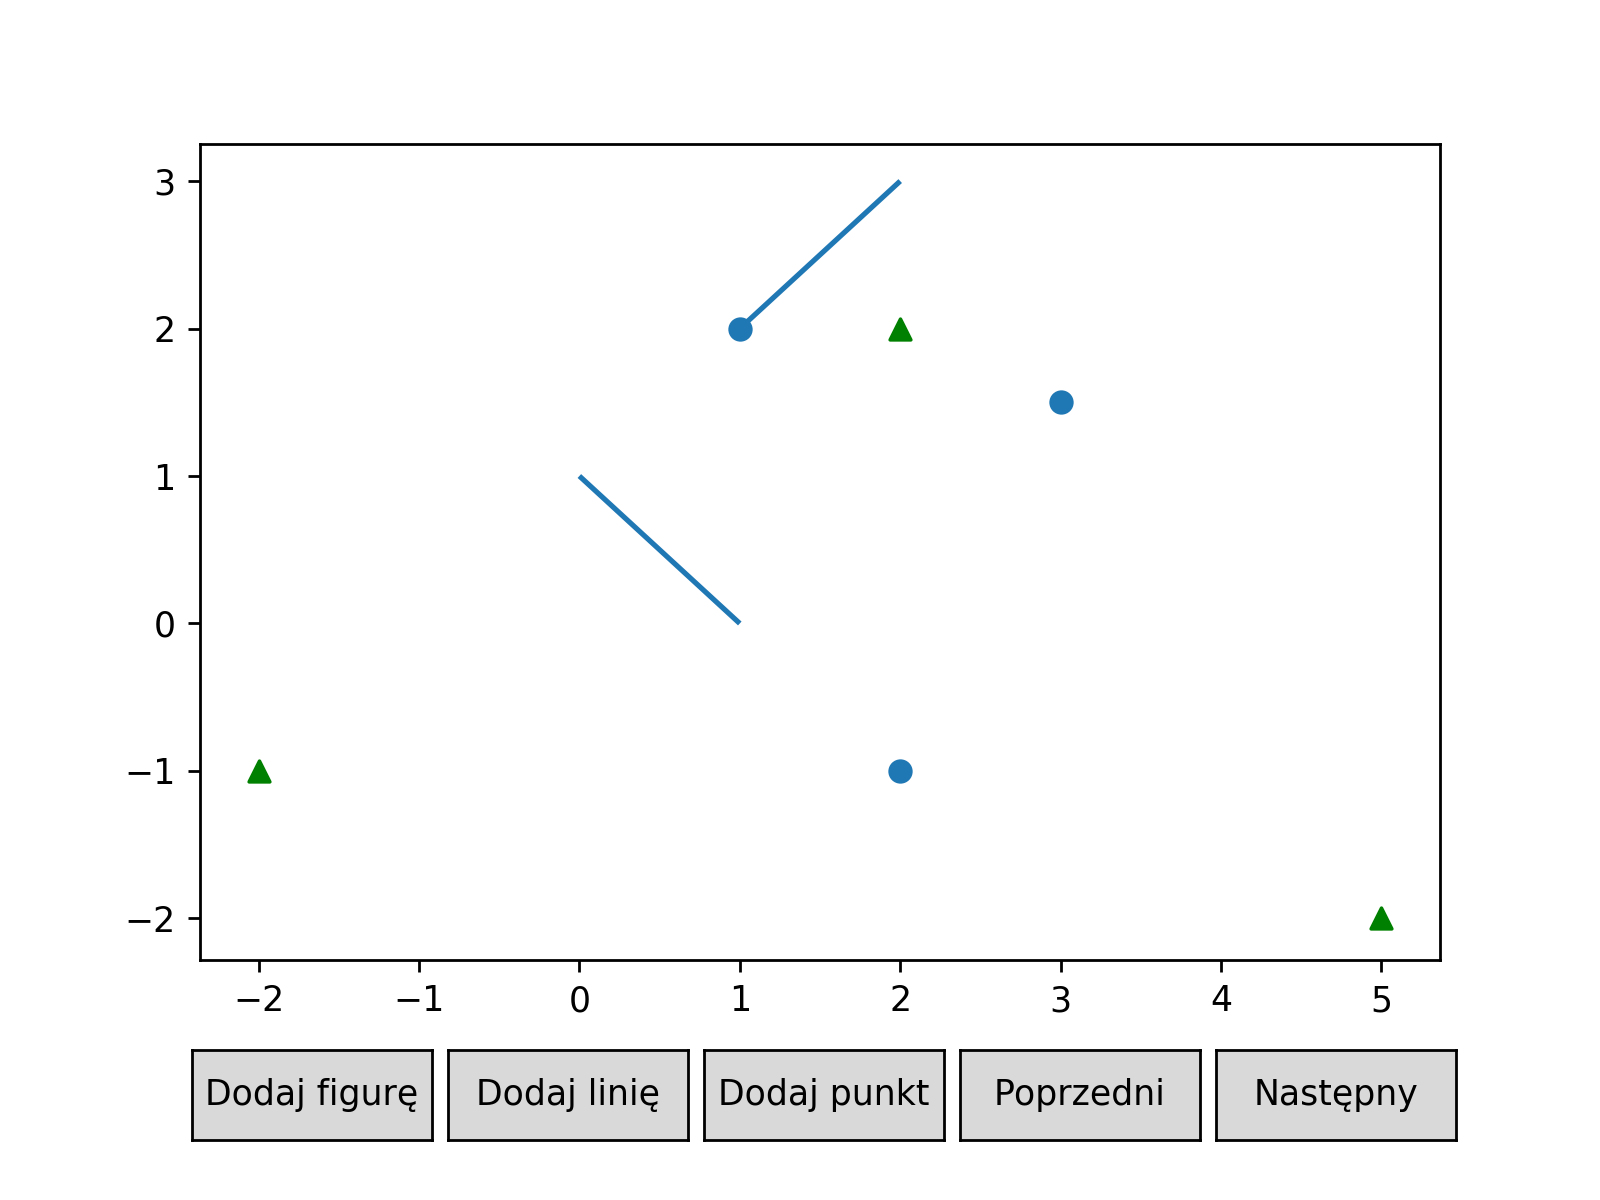

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


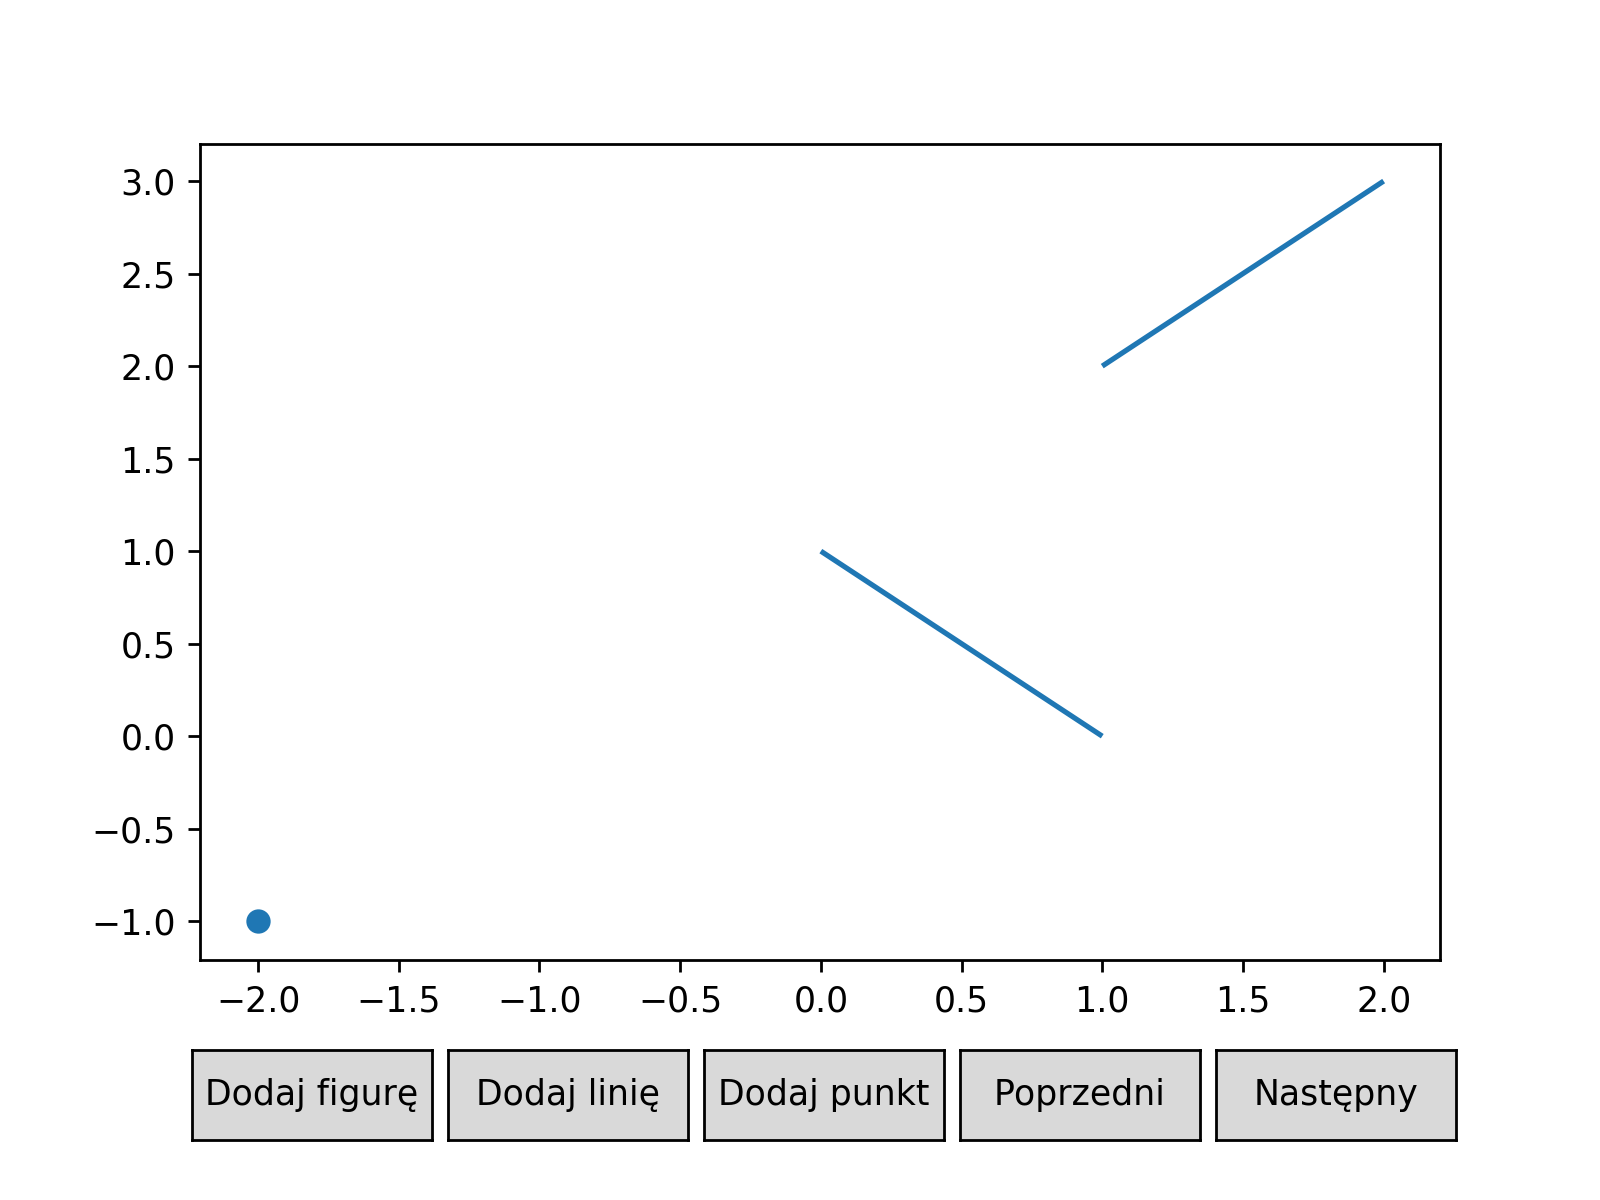

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


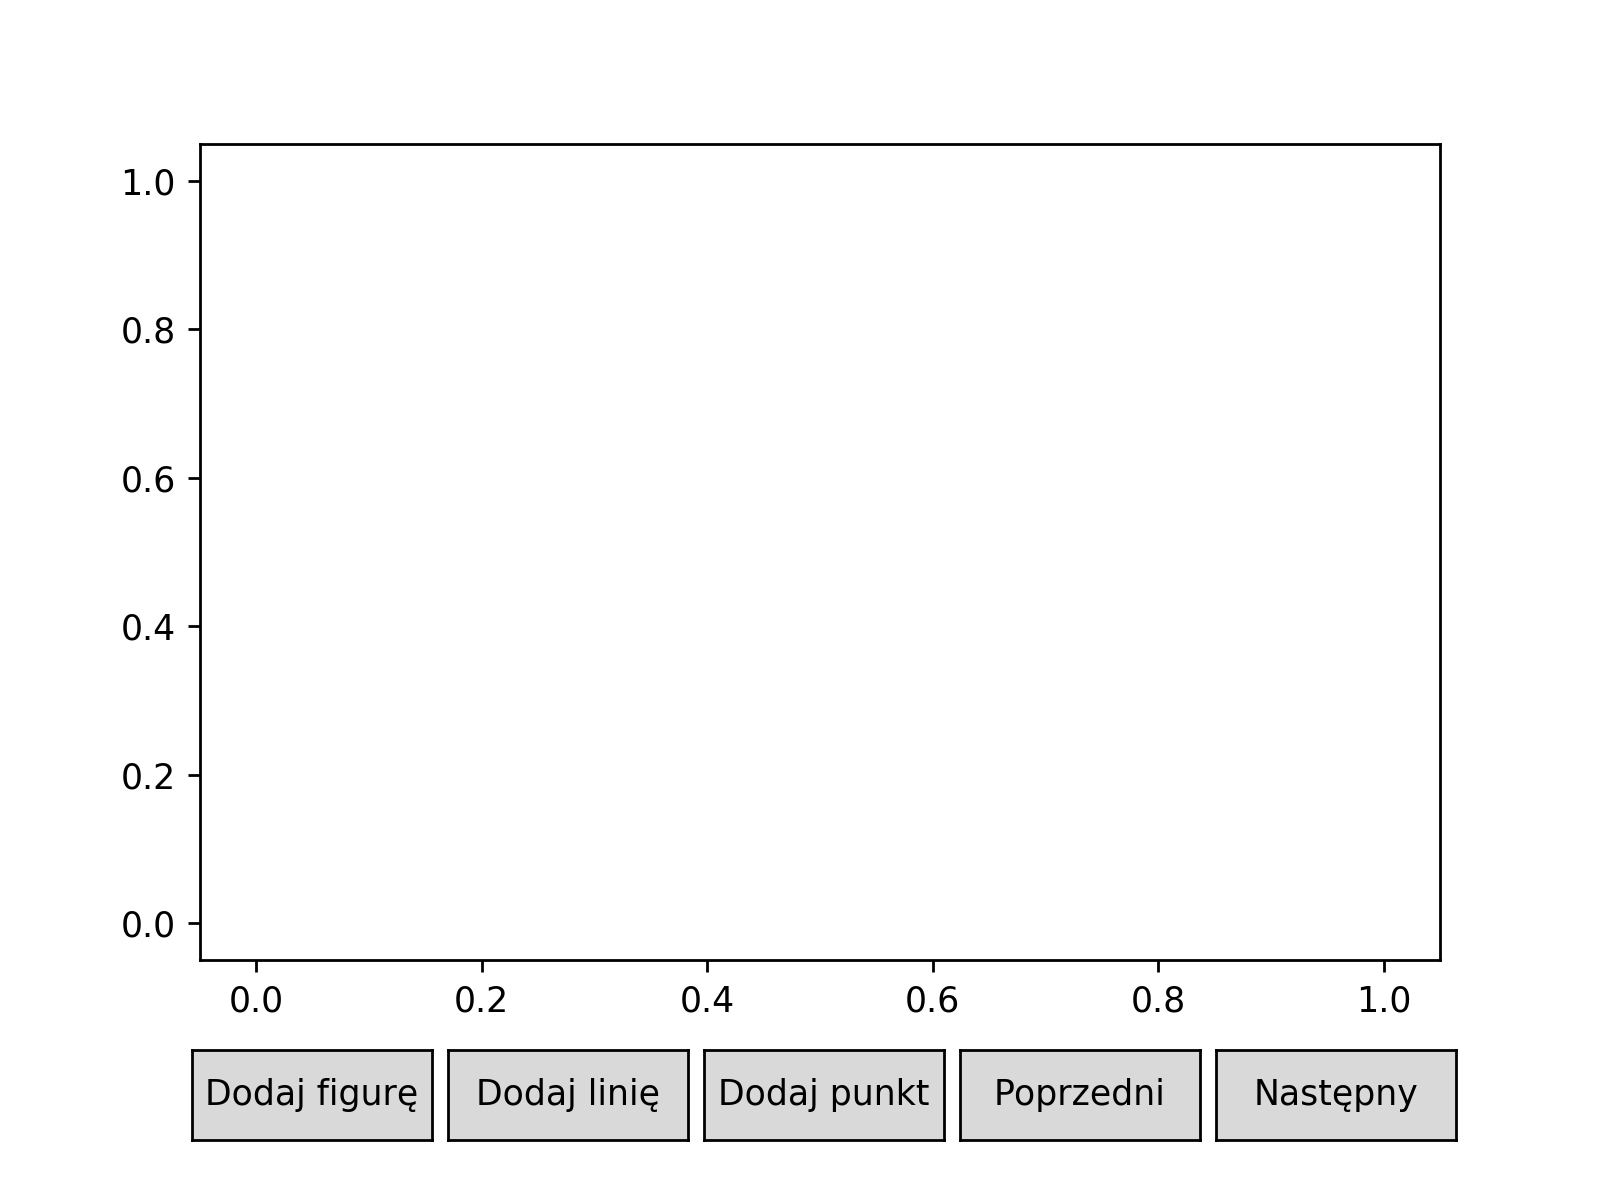

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


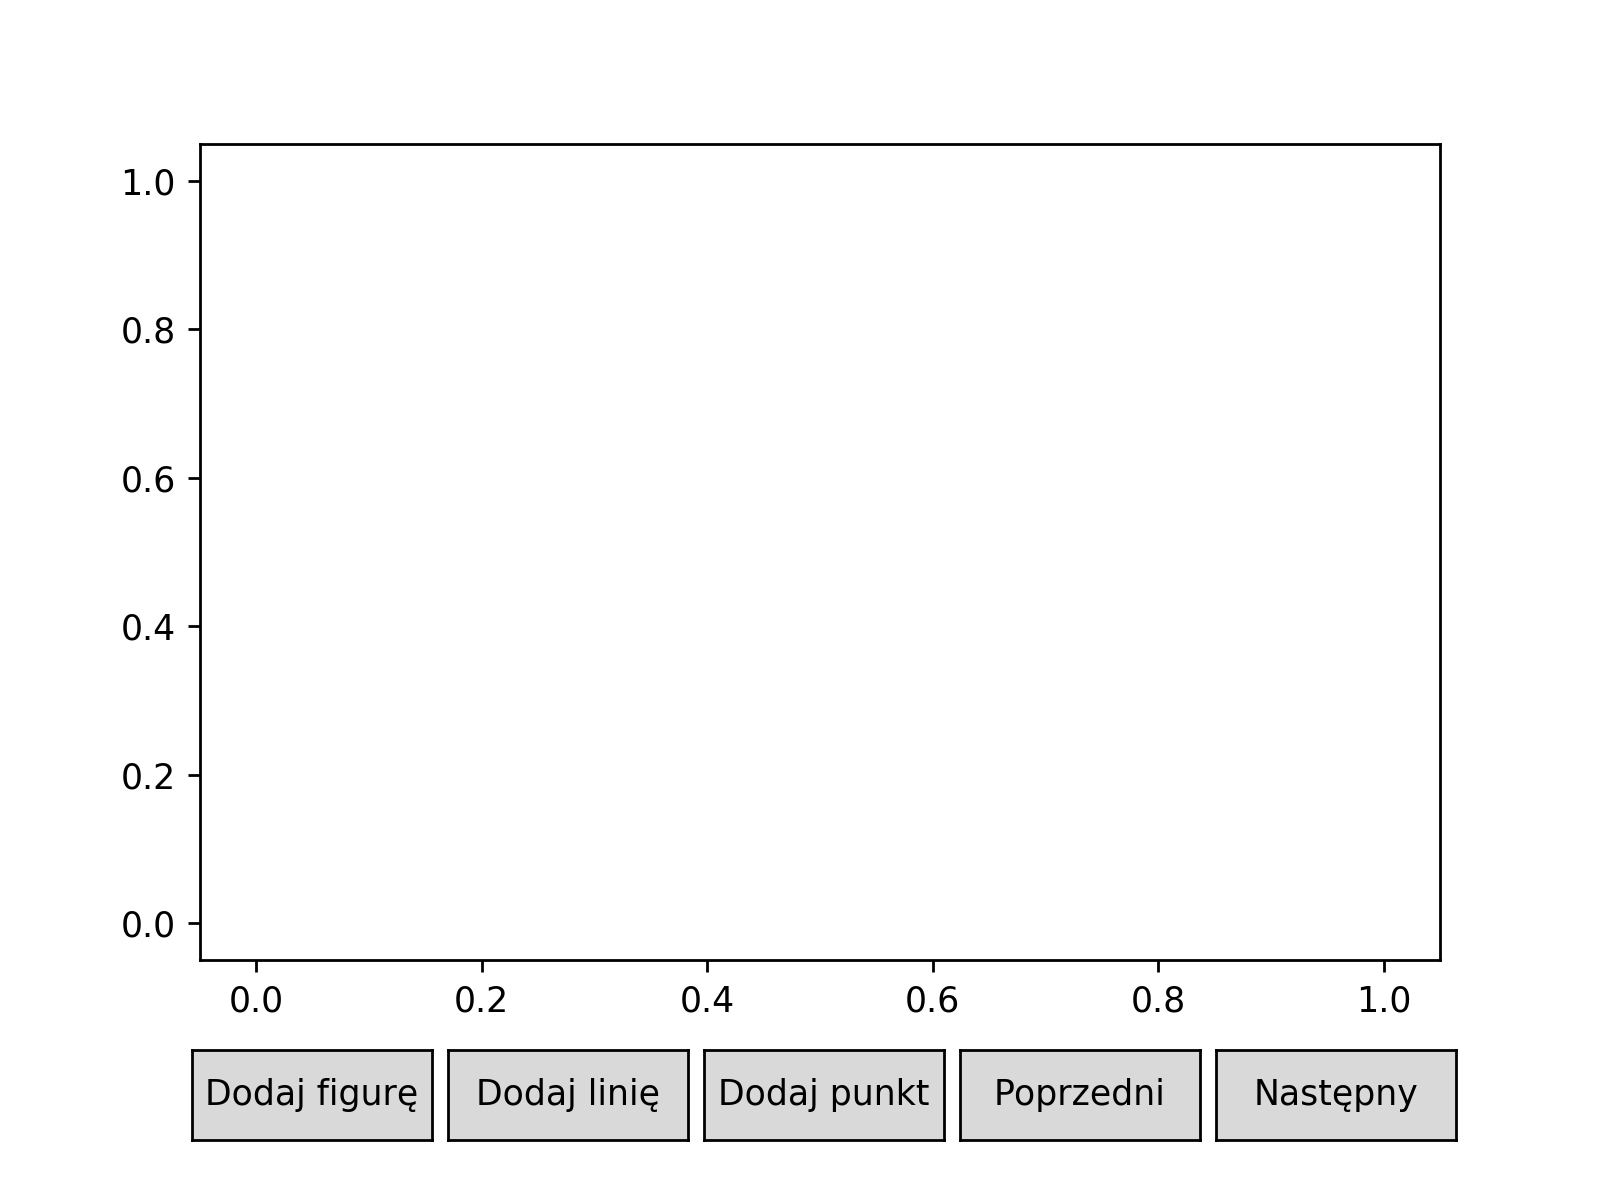

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie
#### Sprawdzanie monotoniczności wielokąta

Pomocnicze do zaokraglania punktu i lini:

In [7]:
def round_point(p, r=2):
    return (round(p[0],r),round(p[1],r))

def round_line(l, r=2):
    return [round_point(l[0],r), round_point(l[1],r)]

def matrix_3x3(point, point_a, point_b):
    matrix = [[point_a[0], point_a[1],1], [point_b[0], point_b[1],1], [point[0], point[1],1]]
    return matrix

def numpy_det(array):
    return np.linalg.det(np.array(array))

In [178]:
%matplotlib notebook
def convert_to_dir_graph(lines):
    if len(lines) == 0:
        return {}
    
    lines = sorted(lines, key = lambda line: line[0][1])
    lines = sorted(lines, key=lambda line:line[0][1], reverse=True)
    
    verticies_adj = {lines[0][0]:{lines[0][1]}}
    
    for line in lines:
        if line[0] in verticies_adj:
            if not(line[1] in verticies_adj[line[0]]):
                verticies_adj[line[0]].add(line[1])
        else:
            verticies_adj[line[0]]={line[1]}
    
    return verticies_adj

def convert_to_undir_graph(lines):
    if len(lines) == 0:
        return {}
    
    lines = sorted(lines, key = lambda line: line[0][1])
    lines = sorted(lines, key=lambda line:line[0][1], reverse=True)
    
    verticies_adj = {lines[0][0]:{lines[0][1]}}
    
    for line in lines:
        if line[0] in verticies_adj:
            verticies_adj[line[0]].add(line[1])
        else:
            verticies_adj[line[0]]={line[1]}
        
        if line[1] in verticies_adj:
            verticies_adj[line[1]].add(line[0])
        else:
            verticies_adj[line[1]]={line[0]}
    
    return verticies_adj

# def check_monotonous(lines):  
#     lines = [round_line(line, r=4) for line in lines]
#     lines = [sorted(line, key = lambda point: point[1], reverse = True) for line in lines]
    
#     starting_point = max(lines, key = lambda line:line[0][1])[0]
#     verticies_adj = convert_to_undir_graph(lines)
#     verticies_adj = {k: list(v) for k, v in verticies_adj.items()}

#     fst_path = verticies_adj[starting_point][0]
#     snd_path = verticies_adj[starting_point][1]
    
#     while fst_path in verticies_adj and min(verticies_adj[fst_path], key=lambda v: v[1])[1] <= fst_path[1]:
#         fst_path = min(verticies_adj[fst_path], key=lambda v: v[1])
    
#     while snd_path in verticies_adj and snd_path != fst_path and min(verticies_adj[snd_path], key=lambda v: v[1])[1] <= snd_path[1]:
#         snd_path = min(verticies_adj[snd_path], key=lambda v: v[1])
    
#     if snd_path == fst_path:
#         return True
#     else:
#         return False
def check_monotonous(lines, paths=False):  
    lines = [round_line(line, r=4) for line in lines]
    lines = [sorted(line, key = lambda point: point[1], reverse = True) for line in lines]
    
    starting_point = max(lines, key = lambda line:line[0][1])[0]
    verticies_adj = convert_to_undir_graph(lines)
    verticies_adj = {k: list(v) for k, v in verticies_adj.items()}

    left = min(verticies_adj[starting_point])
    right = max(verticies_adj[starting_point])
    
    left_path = {left}
    right_path = set()

    while left in verticies_adj and min(verticies_adj[left], key=lambda v: v[1])[1] <= left[1]:
        left = min(verticies_adj[left], key=lambda v: v[1])
        if left in left_path:
            break 
        left_path.add(left)

    if not (right in left_path):
        right_path = {right}
    while right in verticies_adj and right != left and min(verticies_adj[right], key=lambda v: v[1])[1] <= right[1]:
        right = min(verticies_adj[right], key=lambda v: v[1])
        if right in right_path:
            break
        if not (right in left_path):
            right_path.add(right)

    if right == left:
        if paths:
            return (True, left_path, right_path)
        return True
    else:
        return False
    
def classify_points(lines):
    lines = [round_line(line, r=4) for line in lines]
    lines = [sorted(line, key = lambda point: point[1], reverse = True) for line in lines]
    
    starting_point = max(lines, key = lambda line:line[0][1])[0]
    verticies_adj = convert_to_undir_graph(lines)
    verticies_adj = {k: list(v) for k, v in verticies_adj.items()}
    
    starting_points = [starting_point]
    end_points = []
    connecting_points = []
    dividing_points = []
    valid_points = []

    next = max(verticies_adj[starting_point])
    prev = starting_point
    mid = next
    next = verticies_adj[mid][0] if verticies_adj[mid][0] != prev else verticies_adj[mid][1]

    while mid != starting_point:
        det = numpy_det(matrix_3x3(next, mid, prev))
        if mid[1] < next[1] and mid[1] < prev[1]:
            if det > 0:
                end_points.append(mid)
            else:
                connecting_points.append(mid)
        elif mid[1] > next[1] and mid[1] > prev[1]:
            if det > 0:
                starting_points.append(mid)
            else:
                dividing_points.append(mid)
        else:
            valid_points.append(mid)

        
        prev = mid
        mid = next
        next = verticies_adj[mid][0] if verticies_adj[mid][0] != prev else verticies_adj[mid][1]
    
    return {'starting':starting_points,'connecting':connecting_points,'dividing':dividing_points, 'valid':valid_points, 'end':end_points}
    
    
def triangulation(lines):
    lines = [round_line(line, r=4) for line in lines]
    lines = [sorted(line, key = lambda point: point[1], reverse = True) for line in lines]
       
    starting_point = max(lines, key = lambda line:line[0][1])[0]
    
    monotonous, left_path, right_path = check_monotonous(lines, True)

    all_points = sorted(list(left_path) + list(right_path), key=lambda point: point[1], reverse=True)
    stack = []

    stack.append(all_points[0])
    stack.append(all_points[1])
    lines.append([stack[-1], stack[-2]])
    
    prev = all_points[1]
    for point in all_points[2:]:
        if (point in left_path and stack[-1] in right_path) or (point in right_path and stack[-1] in left_path):
            #first = stack[-1]
            while len(stack) >= 1:
                lines.append([point,stack.pop()])
            
            stack.append(prev)
            stack.append(point)
        else:
            if stack[-1] in left_path:
                u1 = stack.pop()
                u2 = stack[-1]
                while len(stack) >= 1 and numpy_det(matrix_3x3(u1, point, u2)) > 0:
                    lines.append([point, u2])
                    if len(stack) == 0:
                        break
                    u1 = u2
                    u2 = stack.pop()
                stack.append(u2)
                stack.append(u1)
                stack.append(point)
            else:
                u1 = stack.pop()
                u2 = stack[-1]
                while len(stack) >= 1 and numpy_det(matrix_3x3(u1, point, u2)) < 0:
                    lines.append([point, u2])
                    if len(stack) == 0:
                        break
                    u1 = u2
                    u2 = stack.pop()
                stack.append(u2)
                stack.append(u1)
                stack.append(point)
        prev = point
    print(stack)
    return lines 

<IPython.core.display.Javascript object>


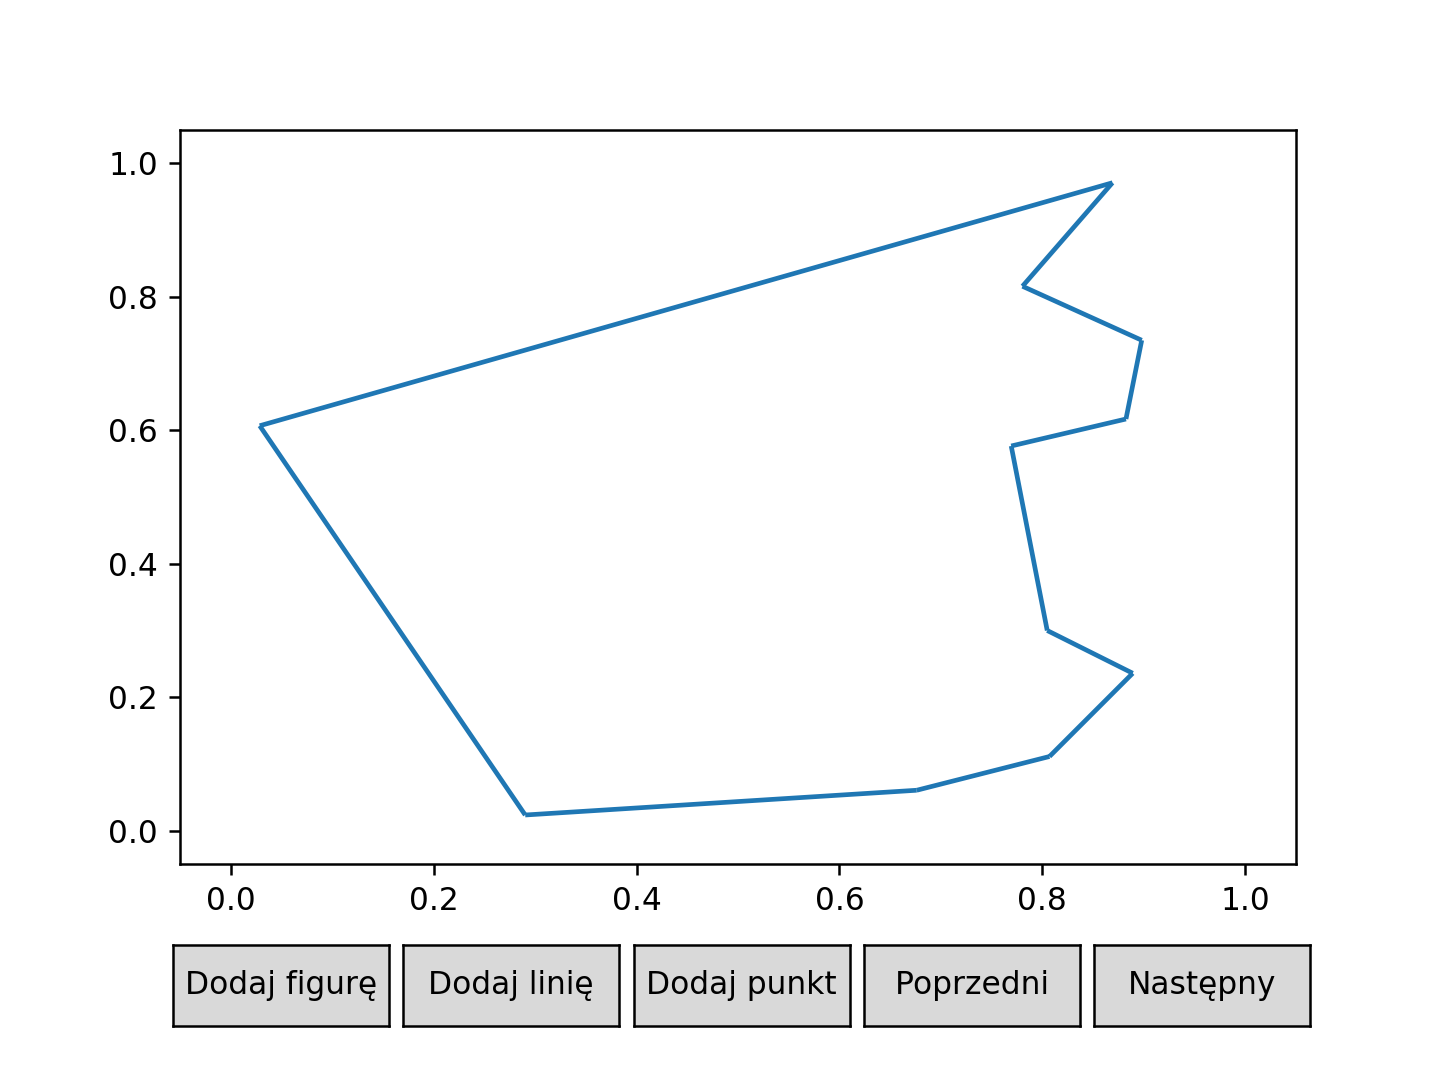

In [189]:
plot = Plot()
plot.draw()

In [190]:
lines = plot.get_added_elements().lines[0].lines
print(check_monotonous(lines, True))

(True, {(0.2903, 0.0234), (0.0286, 0.6064)}, {(0.8048, 0.2997), (0.7693, 0.5761), (0.7804, 0.8154), (0.8824, 0.6165), (0.8979, 0.7345), (0.8891, 0.2357), (0.807, 0.111), (0.6762, 0.0605)})


[]


<IPython.core.display.Javascript object>


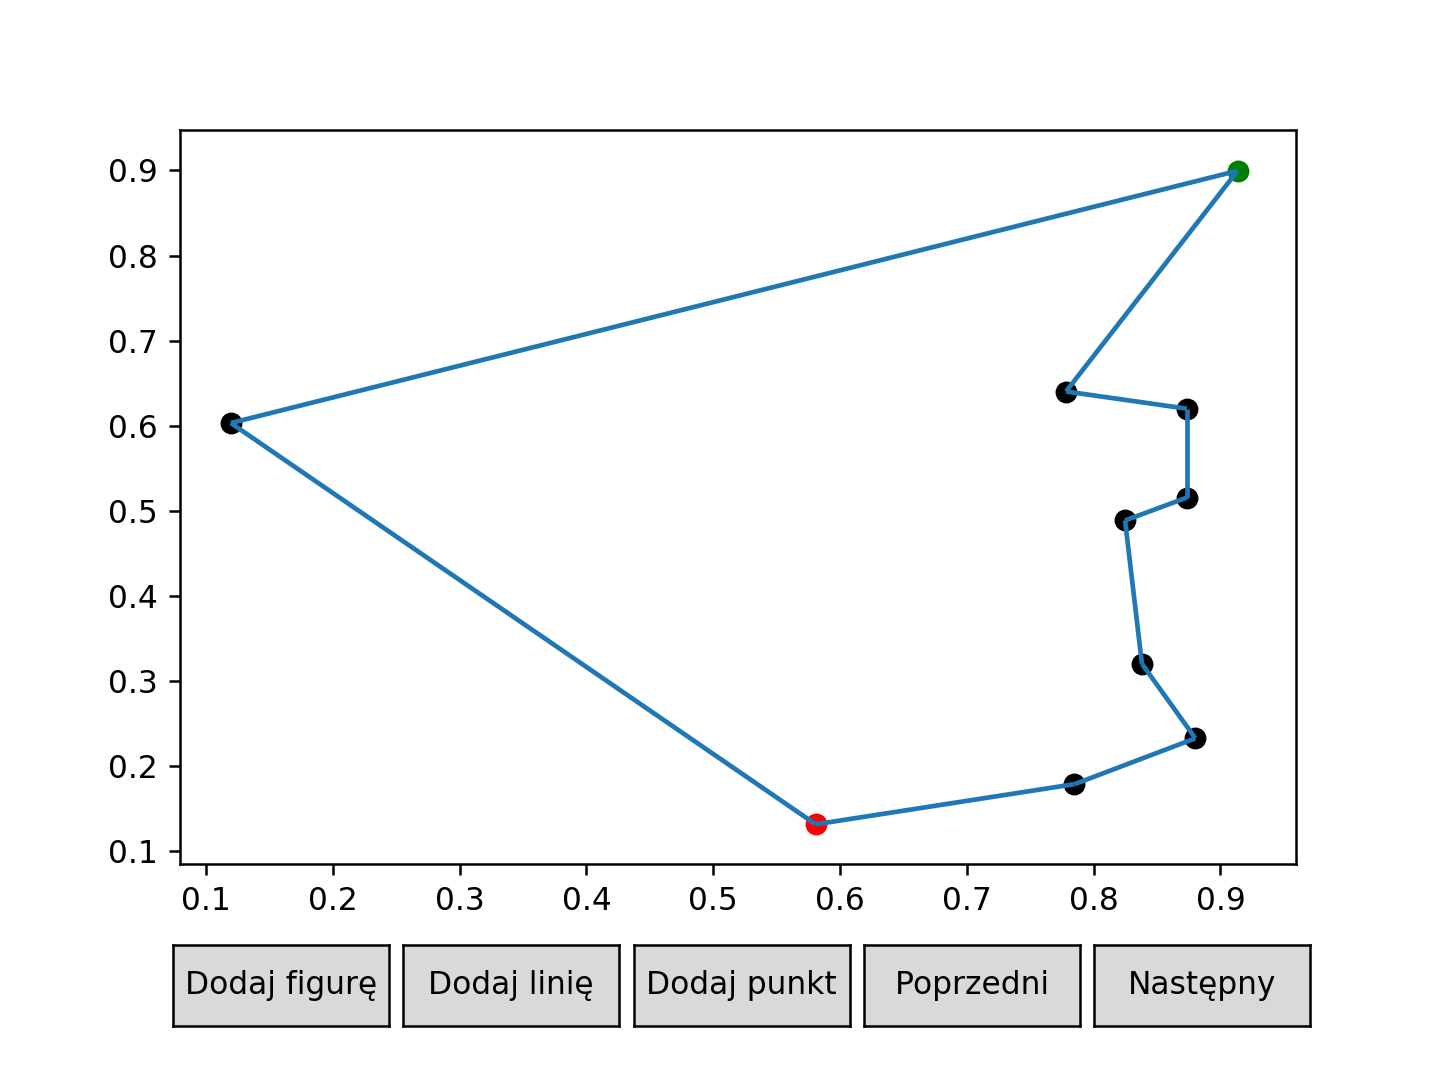

In [186]:
lines = plot.get_added_elements().lines[0].lines
points = classify_points(lines)

scene = plot.get_added_elements()
print(scene.points)
scene.points.append(PointsCollection(points['starting'], color='green'))
scene.points.append(PointsCollection(points['connecting'], color='purple'))
scene.points.append(PointsCollection(points['dividing'], color='blue'))
scene.points.append(PointsCollection(points['valid'], color='black'))
scene.points.append(PointsCollection(points['end'], color='red'))
plot2 = Plot([plot.get_added_elements()])
plot2.draw()

[(0.6762, 0.0605), (0.2903, 0.0234)]


<IPython.core.display.Javascript object>


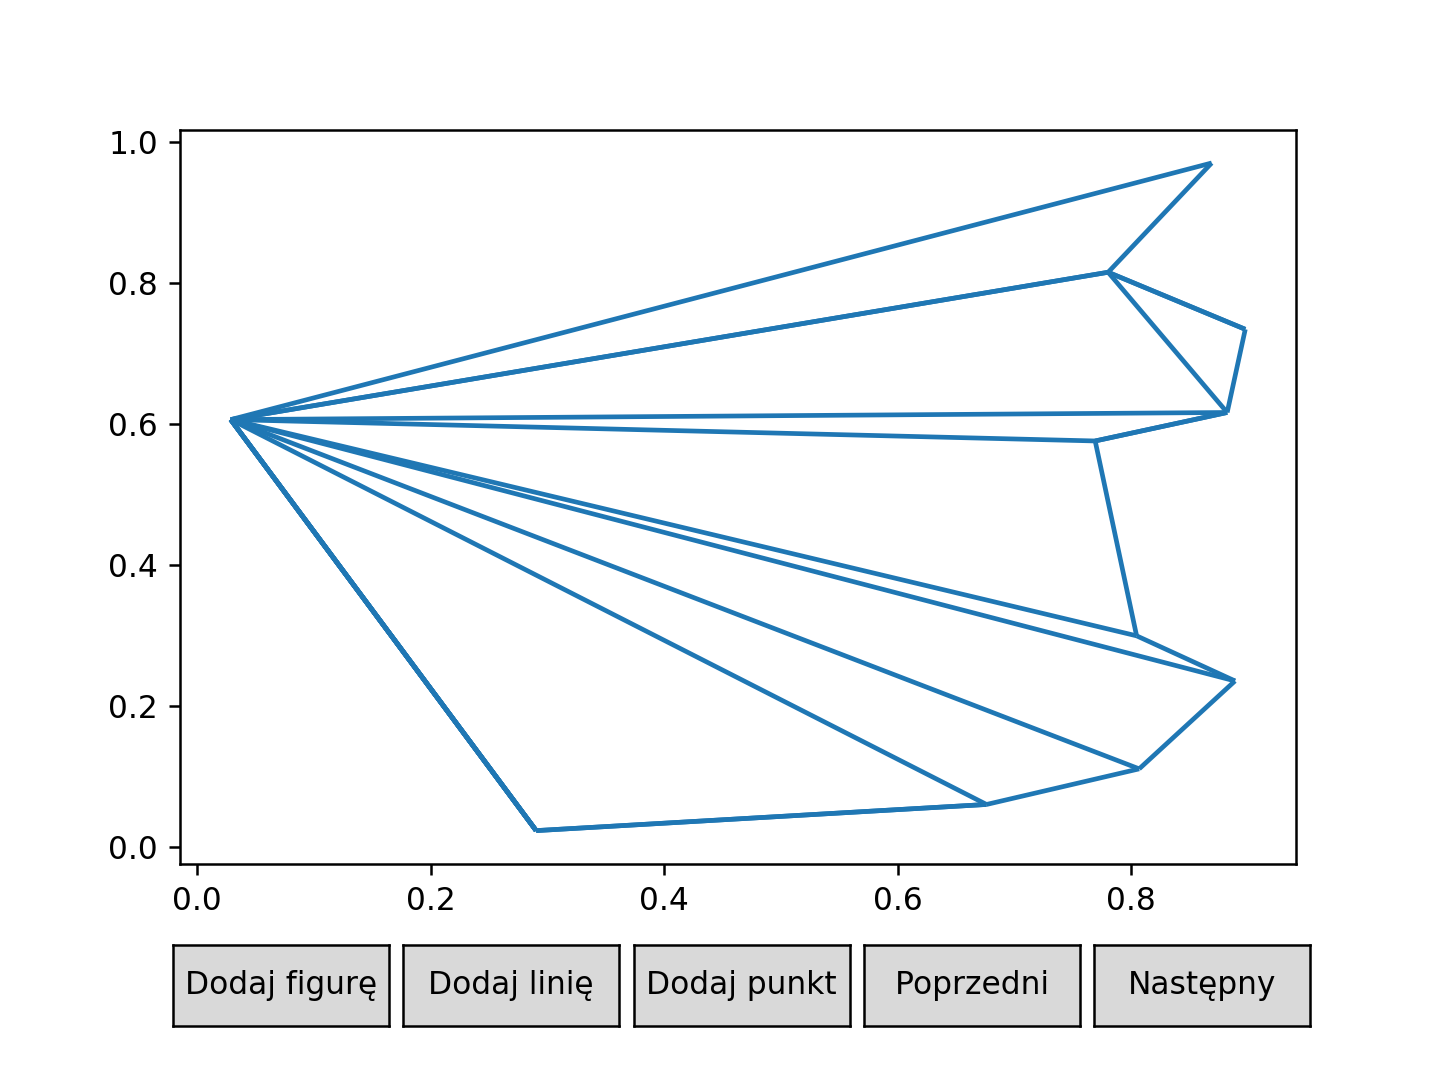

In [192]:
lines = plot.get_added_elements().lines[0].lines
lines = triangulation(lines)

scene = plot.get_added_elements()
scene.lines = []
scene.lines.append(LinesCollection(lines))
plot3 = Plot([scene])

plot3.draw()